In [26]:
import time 
import numpy as np
import pandas as pd
from scipy import signal
import csv
import os
from datetime import datetime
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

import torch
import torch.nn as nn
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from fft_conv_pytorch import fft_conv, FFTConv1d
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [27]:
def upsample_old(x, os_factor):
    out = np.zeros((int(len(x)*os_factor)))
    for i in enumerate(x):
        if i[1] == '1':
            if i[0] == len(x):
                out[int(np.round(i[0]*os_factor,0)):] = 1
            else:
                out[int(np.round(i[0]*os_factor,0)):int(np.round((i[0]+1)*os_factor,0))] = 1 
        return out

def upsample(x, os_factor):
    # recall: os_factor is either ratio of sampling frequency and carrier frequency (fs/fc), 
    # or ratio of bit period (1/bitrate) to sample period (1/fs) - (fs*minbit) for basebanded waveform
    codeArr = np.zeros(len(x))
    for i in enumerate(x):
        if i[1]=='1':
            codeArr[i[0]] = 1    
    bipolCodeArr = codeArr*2-1
    out = np.repeat(codeArr,os_factor)
    return out

def make_BPSK_pulse(A, code, fs, fc, minbit):
    sync = upsample(code, fs*minbit)
    fakeTime = np.arange(0,len(sync))*1/fs
    # For a bpsk pulse this works because pi is 180 degrees, so pi*1 and pi*0 gives a phase difference of 180 degrees, with 180 degrees encoding binary 1, and 0 encoding binary 0
    # What if I shift the phase so that both values are nonzero?
    bpskPulse = A*np.exp(1j*(2*np.pi*fc*(fakeTime+np.pi*sync)))
    return bpskPulse             

In [107]:
def init_process(rank, size, backend='nccl'):
    os.environ["MASTER_ADDR"] = "192.168.1.174"
    os.environ["MASTER_PORT"] = "30000"
    dist.init_process_group(backend = backend,
                            init_method ="env://",
                            world_size = size,
                            rank = rank
                           )

class FilterBank(nn.Module):
    def __init__(self,input_channel,num_filters,filter_length,weights = None,stride = 1,norm = None):
        super().__init__()
        self.conv = nn.Conv1d(input_channel,num_filters,filter_length,padding = 0,stride = stride,bias = False)

    def forward(self, x):
        output = self.conv(x)
        return output

class SigData(Dataset):
    def __init__(self, data, fs):
        self.x_delta = 1/fs # define sample time between points
        self.data = data
    def __getitem__(self, index):
        data = self.data.cpu().numpy()
        x = torch.from_numpy(data.reshape((1, -1))).float()
        y = torch.arange(0, len(data))
        return x, y, index
    def __len__(self):
        return int(self.size)    
    
def z_transform(x):
    m = torch.mean(x, 2).unsqueeze_(2)
    s = torch.std(x, 2).unsqueeze_(2)
    return torch.abs((x - m) / s )

def db_transform(x):
    x = torch.abs(x)
    m = torch.mean(x)
    return 20 * torch.log10(x / m)

def inference(model, dataloader, device, out_dir, filter_time_dict, x_delta=1, detection=z_transform, threshold=4, stride=1):
    model = model.to(device)
    for inputs, indices, index in dataloader:
        with torch.no_grad():
            inputs = inputs.to(device)
            indices = indices.to(device)
            outputs = model(inputs)
            end = int(outputs.shape[-1] * stride)
            indices = indices[:, :end:stride]
            outputs = detection(outputs)
            mask = outputs.ge(threshold)
            values = torch.nonzero(mask)
        outputs = outputs[values[:, 0], values[:, 1], values[:, 2]].data.cpu().numpy()
        filters = values[:, 1].data.cpu().numpy()
        indices = indices[0][values[:, 2]].data.cpu().numpy()
        filter_time_add = np.zeros(filters.shape[0])
        for f in np.unique(filters):
            idx = np.where(filters == f)
            filter_time_add[idx] = filter_time_dict[int(f)] // 2
        toa = (indices + filter_time_add) * x_delta
        write_results_df(toa, outputs, filters, out_dir, index)
    return

# Generate test pulse

### Define globals

In [142]:
A = 1
fs = 25e6
noiseAmp = 100
minbit = 1e-6
bitrate = 1/minbit
fc = 5e6
words = pd.read_csv("allPossible8bitWords.csv",dtype=str)      
randCodes = words.sample(n=5).reset_index()
combCode = ''
for val in randCodes.Code:
    combCode += val
pw = len(combCode)*minbit
t = np.arange(-pw/2, pw/2, 1/fs)
bigT = np.arange(-3*pw/2, 3*pw/2, 1/fs)
raw_sig = make_BPSK_pulse(A, combCode, fs, fc, minbit)
testPulse = np.hstack(((1/2)*np.random.normal(0,1,len(t)),raw_sig + (1/5)*np.random.normal(0,1,len(t)),(1/2)*np.random.normal(0,1,len(t))))
# Also add a bunch of plain noise values on either side. 
print(f'The chosen code for this example is {combCode}')
print(f'The random-code pulse has {len(testPulse)} samples')

The chosen code for this example is 0010001100011111000001101101011100011000
The random-code pulse has 3000 samples


In [143]:
torchTestSignal = torch.zeros([1,1,len(testPulse)],dtype=torch.cfloat)
torchTestSignal[0,0,:] = torch.complex(torch.tensor(testPulse.real),torch.tensor(testPulse.imag))
print(f'The pytorch formatted pulse has {torchTestSignal.shape[2]} samples and total shape {torchTestSignal.shape}')

The pytorch formatted pulse has 3000 samples and total shape torch.Size([1, 1, 3000])


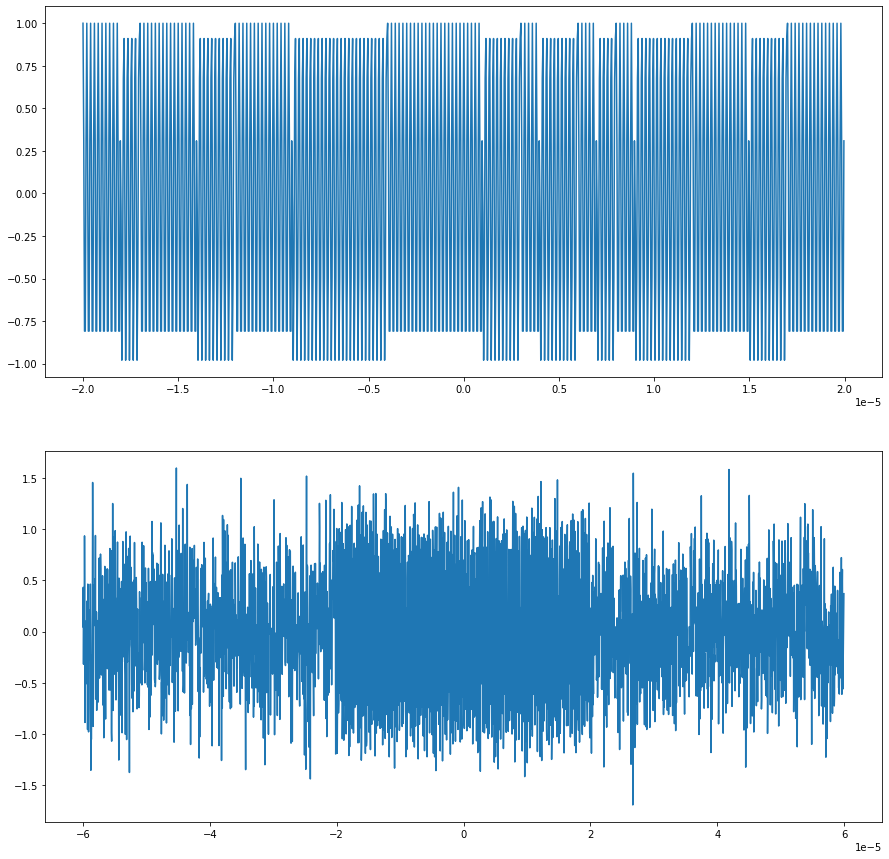

In [144]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(t,raw_sig.real)
plt.subplot(2,1,2)
plt.plot(bigT,testPulse.real)

### Make filter bank

In [145]:
words = pd.read_csv("/Users/cgzog/Python_Projects/allPossible8bitWords.csv",dtype=str)
pw = 8/bitrate
t = np.arange(-pw/2, pw/2, 1/fs)
filterBank = torch.zeros([words.shape[0],1,len(t)],dtype=torch.cfloat)
for index,row in words.iterrows():
    pulse = make_BPSK_pulse(A, words.Code[index], fs, fc, 1/bitrate)  # decide later
    complexPulse = torch.complex(torch.tensor(pulse.real),torch.tensor(pulse.imag))
    filterBank[index,0,:] = complexPulse
    
scipyFilters = filterBank.data.cpu().numpy()
print(f'The filter bank has {scipyFilters.shape[0]} filters that are each {scipyFilters.shape[2]} samples long')

The filter bank has 256 filters that are each 200 samples long


### Convolve signal with filter bank

In [146]:
# This is predicated that complex 1d convolution produces 4 convolutional outputs: (if [a+bi]*[c+di]) then return (a*c - b*d) + j(a*d+b*c)
# So declare a convolutional MODEL. WIth the nn.conv1d yadda yadda
# Then, call your new model on the input data
def cmplxCnv(sigInput, filterBank):
    iData = sigInput.real 
    qData = sigInput.imag
    
    imodel = FilterBank(1, filterBank.shape[0], filterBank.shape[2], filterBank.real)
    qmodel = FilterBank(1, filterBank.shape[0], filterBank.shape[2], filterBank.imag)
    with torch.no_grad():
        iOut = imodel(iData)-qmodel(qData)
        qOut = imodel(qData)+qmodel(iData)
        iOut = z_transform(iOut)
        qOut = z_transform(qOut)
    return torch.complex(iOut,qOut)

In [147]:
outputs = cmplxCnv(torchTestSignal, filterBank)
# So dimension 0 is indices, which is singleton in this case because I didn't tell it to distribute
# dimension 1 is number of filters
# dimension 2 is the convolutional response per filter
indices = np.arange(0,outputs.shape[2]) + outputs.shape[1]/2
filters = outputs[:, 1].data.cpu().numpy()
convResp = outputs[:, 2].data.cpu().numpy()
toa = indices * 1/fs

In [151]:
convResp[0].shape

(2801,)

C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


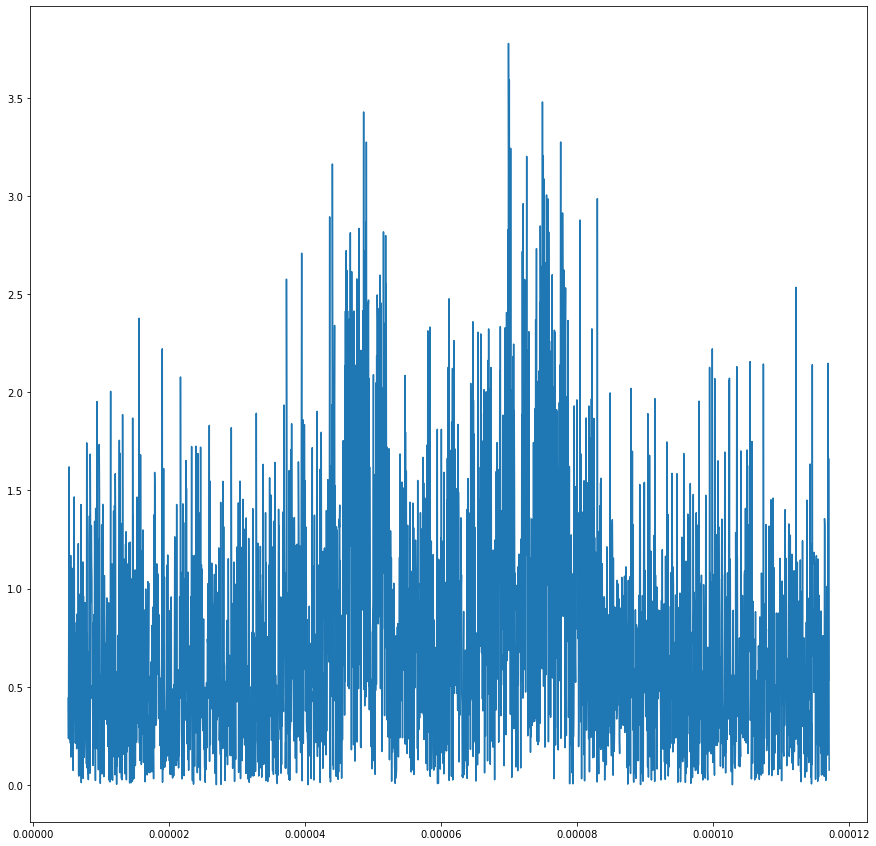

In [150]:
plt.figure(figsize=(15,15))
plt.plot(toa,convResp[0])

Text(0.5, 1.0, 'Complex match filtered result dB')

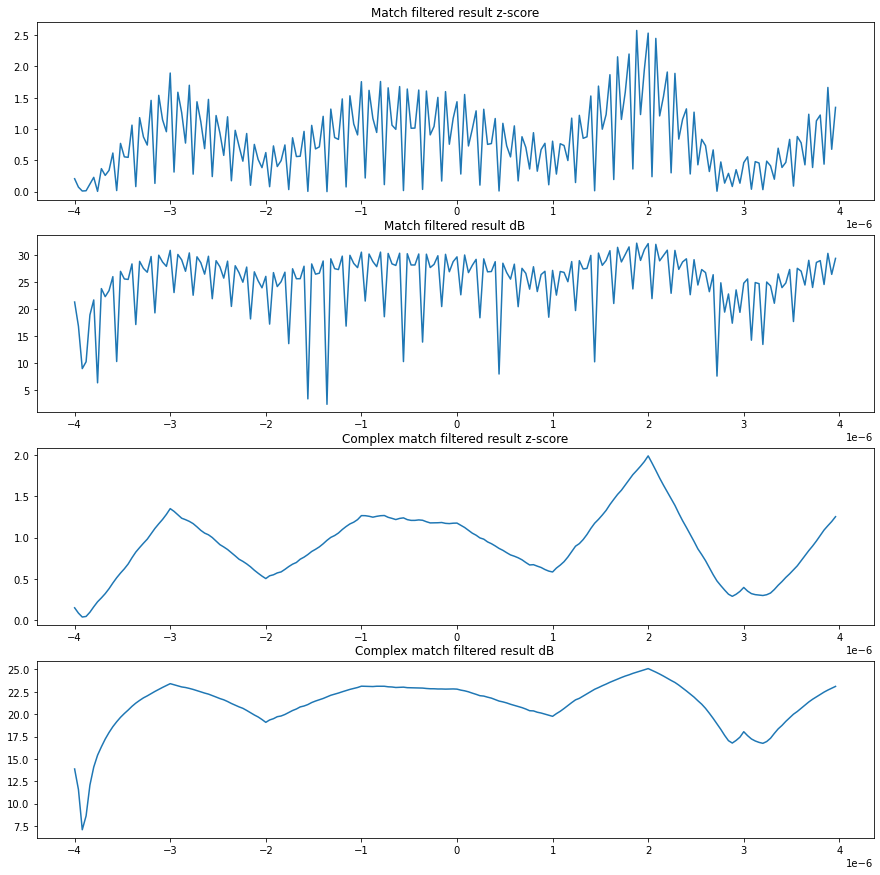

In [23]:
goodFiltered = signal.convolve(pulse.real, raw_sig.real, mode='same')
goodFilteredComplex = signal.convolve(pulse, raw_sig, mode='same')
gudPSD = 10 * np.log10(np.abs(goodFiltered/np.mean(goodFiltered)))
gudZ = np.abs((goodFiltered - np.mean(goodFiltered))/(np.std(goodFiltered)))
gudCplxPSD = 10 * np.log10(np.abs(goodFilteredComplex/np.mean(goodFilteredComplex)))
gudCplxZ = np.abs((goodFilteredComplex - np.mean(goodFilteredComplex))/(np.std(goodFilteredComplex)))
# To compute z-score, take convolution output, subtract mean, and then divide by standard deviation
# To compute power, take 20 * log_base10 of (the output / mean)

plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
plt.plot(t,np.abs(gudZ))
plt.title('Match filtered result z-score')
plt.subplot(4,1,2)
plt.plot(t,np.abs(gudPSD))
plt.title('Match filtered result dB')
plt.subplot(4,1,3)
plt.plot(t,np.abs(gudCplxZ))
plt.title('Complex match filtered result z-score')
plt.subplot(4,1,4)
plt.plot(t,np.abs(gudCplxPSD))
plt.title('Complex match filtered result dB')

In [ ]:
# Mismatched filtering for decoding a laarge symbol-encoded waveform


In [12]:
# I have 200 points, that need to reduce to 8 points. I have number of samples in a pulse = 200, each pulse corresponds to 8 bits, with a minbit of 1e-6. My sample rate is 25e6, or 40ns. 
# so I have One bit = 1e-6/40e-9, or 25 samples per bit. Odd numbers are good here because I could theoretically just find a local max, count 12 points from either side, and average 
# those values. 

samplesPerBit = 1e-6*fs #minbit * sample rate
idx = signal.argrelextrema(goodFiltered, np.greater, order=round(int(samplesPerBit*2))) # If you slide out twice the number of samples in a bit when comparing local maxima
# then theoretically I should find like an overruling point that trumps all other points. I'd have to try this with more than one pulse
# Once I find the index I want, I go back to working in samples per bit. I need to "map" each pulse/signal and then section of an appropriate number of bits per sample for each one,
# Then vote/average them all together. Alternatively do I just find a local max on order of length of a pulse (when dealing with a pulse train) and then assign those bits as an output?
# The problem with a lot of these is I will need to stamp every sample and my convolution threshold might exclude certain samples that fall below threshold. And then if THAT happens
# I need to somehow track an index so that I don't lump a neighboring point into my current point's averaging. 
# ALSO NEED TO TRACK TIME

(array([  4,  99, 195], dtype=int64),)


# To Be Implemented

### This is the Muller and Mueller Clock Recovery Technique

C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


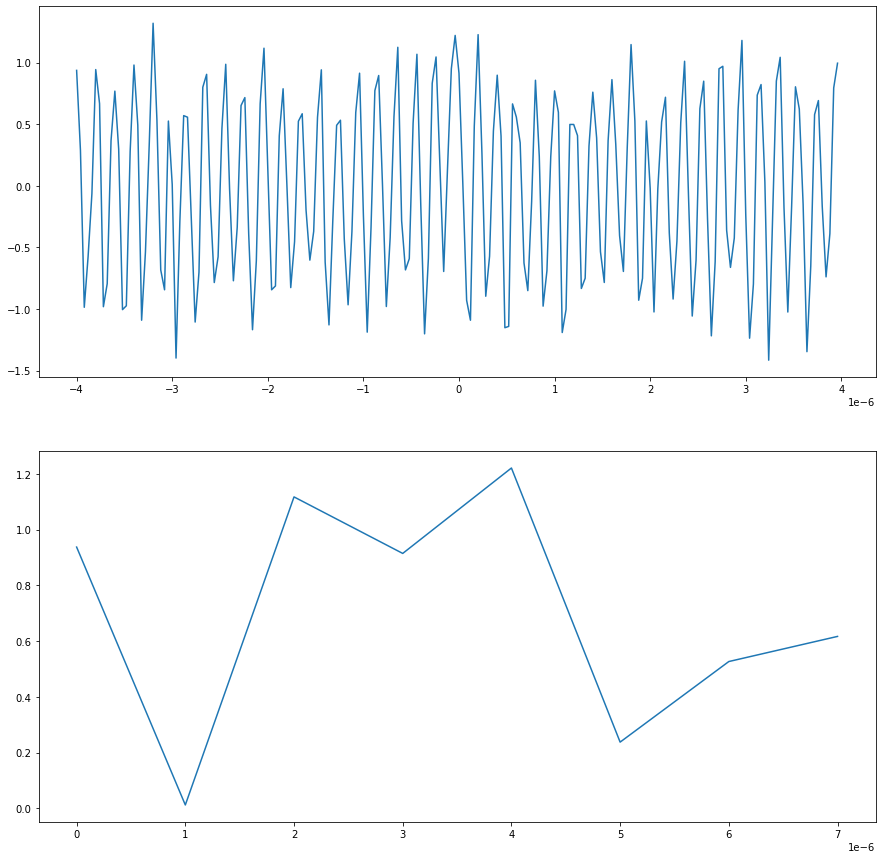

In [16]:
# Using pulse value calculated above
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(pulse) + 10, dtype=complex)
out_rail = np.zeros(len(pulse) + 10, dtype=complex) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(pulse) and i_in+16 < len(pulse):
    out[i_out] = pulse[i_in + int(mu)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    sps = samplesPerBit # If I understand this, this is samples PER symbol (bit), or it's symbols (bits) per sample
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples = out # only include this line if you want to connect this code snippet with the Costas Loop later on
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(t,pulse)
plt.subplot(2,1,2)
plt.plot(np.arange(0,8*minbit,minbit),samples)

### The Costas Loop for Fine Frequency Synchronization (as opposed to Coarse Frequency Synchronization)

In coarse frequency synchronization we square (BPSK) or square-square (totally a real math term) (QPSK) the incoming signal, find the frequency offset from that and subtract it off, then theoretically can demodulate our signal.

In [ ]:
N = len(samples)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
alpha = 0.132
beta = 0.00932
out = np.zeros(N, dtype=np.complex)
freq_log = []
for i in range(N):
    out[i] = samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * fs / (2*np.pi)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi

# Plot freq over time to see how long it takes to hit the right offset
plt.plot(freq_log,'.-')
plt.show()